In [1]:
import numpy as np
import pyvista as pv
import os
import random
from tqdm import tqdm
from scipy.sparse import csr_matrix
from scipy.spatial import Delaunay
from fast_matching_python.fast_marching import fast_marching
from make_surface_dataset import fmm


def make_uniform_surface_multimesh(f=None, radius=1.0, spacing=0.01, sparse_strides=[10]):
    """
    Generate a fine and coarse uniform triangular mesh over z = f(x,y)
    Returns:
        (fine_graph, fine_faces, fine_points, fine_mesh, fine_h),
        (coarse_graph, coarse_faces, coarse_points, coarse_mesh, coarse_h)
    """
    if f is None:
        f = lambda x, y: np.sin(np.pi * x) * np.sin(np.pi * y)
        
        
    # === Helper to build graph and h ===
    def build_graph_and_h(points3d, faces):
        edge_set = set()
        rows, cols, dists, edge_lengths = [], [], [], []
        for face in faces:
            for i in range(3):
                a, b = face[i], face[(i+1)%3]
                edge = tuple(sorted((a,b)))
                if edge not in edge_set:
                    edge_set.add(edge)
                    dist = np.linalg.norm(points3d[a] - points3d[b])
                    edge_lengths.append(dist)
                    rows += [a, b]
                    cols += [b, a]
                    dists += [dist, dist]
        graph = csr_matrix((dists, (rows, cols)), shape=(len(points3d), len(points3d)))
        h = np.mean(edge_lengths)
        return graph, h


    # === Fine hex grid ===
    x_range = np.arange(-radius, radius + spacing, spacing)
    y_range = np.arange(-radius, radius + spacing * np.sqrt(3)/2, spacing * np.sqrt(3)/2)
    xx, yy = np.meshgrid(x_range, y_range)
    xx[::2, :] += spacing / 2  # Hexagonal shift

    x_fine = xx.ravel()
    y_fine = yy.ravel()
    z_fine = f(x_fine, y_fine)
    points2d_fine = np.column_stack((x_fine, y_fine))
    points3d_fine = np.column_stack((x_fine, y_fine, z_fine)).astype(np.float32)

    tri_fine = Delaunay(points2d_fine)
    faces_fine = tri_fine.simplices

    mesh_fine = pv.PolyData()
    mesh_fine.points = points3d_fine
    mesh_fine.faces = np.hstack([[3, *face] for face in faces_fine])

    graph_fine, h_fine = build_graph_and_h(points3d_fine, faces_fine)

    # === Coarse mesh: subsample using stride in 2D grid ===
    sub_meshes = []
    for sparse_stride in sparse_strides:
        mask = np.zeros(xx.shape, dtype=bool)
        mask[::sparse_stride, ::sparse_stride] = True
        x_coarse = xx[mask]
        y_coarse = yy[mask]
        z_coarse = f(x_coarse, y_coarse)
        points2d_coarse = np.column_stack((x_coarse, y_coarse))
        points3d_coarse = np.column_stack((x_coarse, y_coarse, z_coarse)).astype(np.float32)

        tri_coarse = Delaunay(points2d_coarse)
        faces_coarse = tri_coarse.simplices

        mesh_coarse = pv.PolyData()
        mesh_coarse.points = points3d_coarse
        mesh_coarse.faces = np.hstack([[3, *face] for face in faces_coarse])

        
        graph_coarse, h_coarse = build_graph_and_h(points3d_coarse, faces_coarse)
        
        sub_meshes.append((graph_coarse, faces_coarse, points3d_coarse, mesh_coarse, h_coarse))


    coordinates_to_fine_point_index = {tuple(coor): idx for idx, coor in enumerate(points3d_fine)}
    return ((graph_fine, faces_fine, points3d_fine, mesh_fine, h_fine), sub_meshes, coordinates_to_fine_point_index)


In [2]:
import numpy as np

# 1. Radial sine ripple
def ripple(x, y, A=1.0, k=2):
    r = np.sqrt(x**2 + y**2)
    return A * np.sin(k * r)

# 2. Gaussian “bump” or hill
def gaussian_hill(x, y, A=3.0, sigma=1.5):
    return A * np.exp(-((x**2 + y**2) / (2 * sigma**2)))

# 3. Mexican hat (Ricker) wavelet
def mexican_hat(x, y, A=3.0, sigma=1.5):
    r2 = x**2 + y**2
    s2 = sigma**2
    return A * (1 - r2/s2) * np.exp(-r2/(2*s2))

# 4. Saddle surface (hyperbolic paraboloid)
def saddle(x, y, a=2.0, b=2.0):
    return (x**2 / a**2) - (y**2 / b**2)

# 5. Elliptic paraboloid (bowl)
def paraboloid(x, y, a=2.0, b=2.0):
    return (x**2 / a**2) + (y**2 / b**2)

# 6. Sinusoidal grid waves
def grid_waves(x, y, A=0.5, kx=3.0, ky=3.0):
    return A * (np.sin(kx * x) + np.sin(ky * y))

# 7. Checkerboard of Gaussian bumps
def bump_grid(x, y, A=1.0, sigma=0.5, spacing=3):
    # place little Gaussians at grid centers
    xi = np.round(x/spacing) * spacing
    yi = np.round(y/spacing) * spacing
    return A * np.exp(-(((x-xi)**2 + (y-yi)**2) / (2*sigma**2)))

# 11. User‐combination: mix two surfaces
def mix_surfaces(f1, f2, alpha=0.5):
    return lambda x, y: alpha*f1(x, y) + (1-alpha)*f2(x, y)

def omer_test(x, y, A=1.0, k=0.4):
    r = x**2 + y**2
    return A * np.sin(k * r)


omer_test with params {'A': 1.0, 'k': 0.4}, high resolution h = 0.008644839748740196


/home/omer.trinin/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


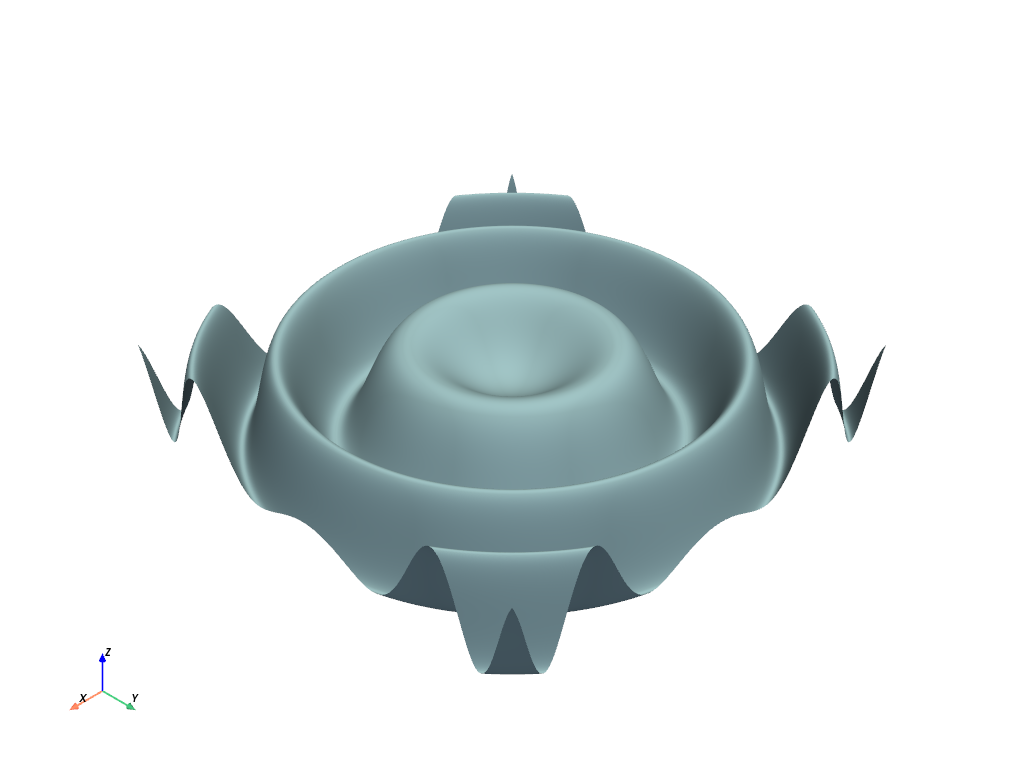

sparse resolution h = 0.27372419834136963
[                                                  ]                                                   ] 0%

/home/omer.trinin/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


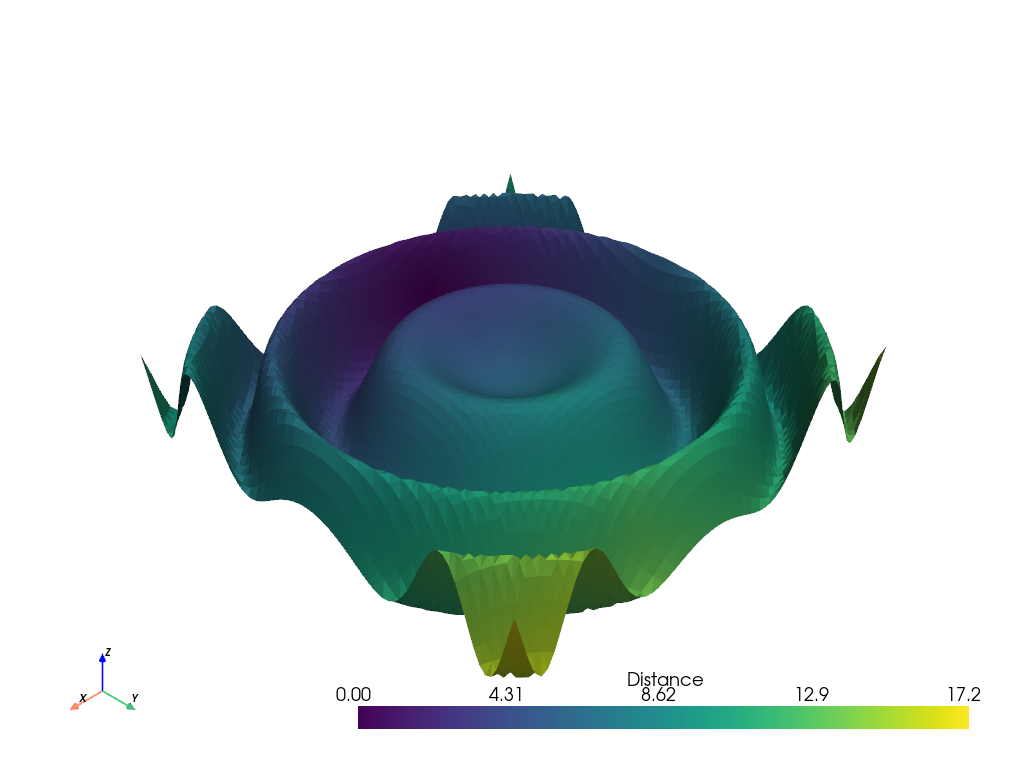

✓ Saved function_omer_test_0_h_0.274_source_695.txt (h = 0.274, points = 5226)
sparse resolution h = 0.36348798871040344
[                                                  ]                                                   ] 0%

/home/omer.trinin/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


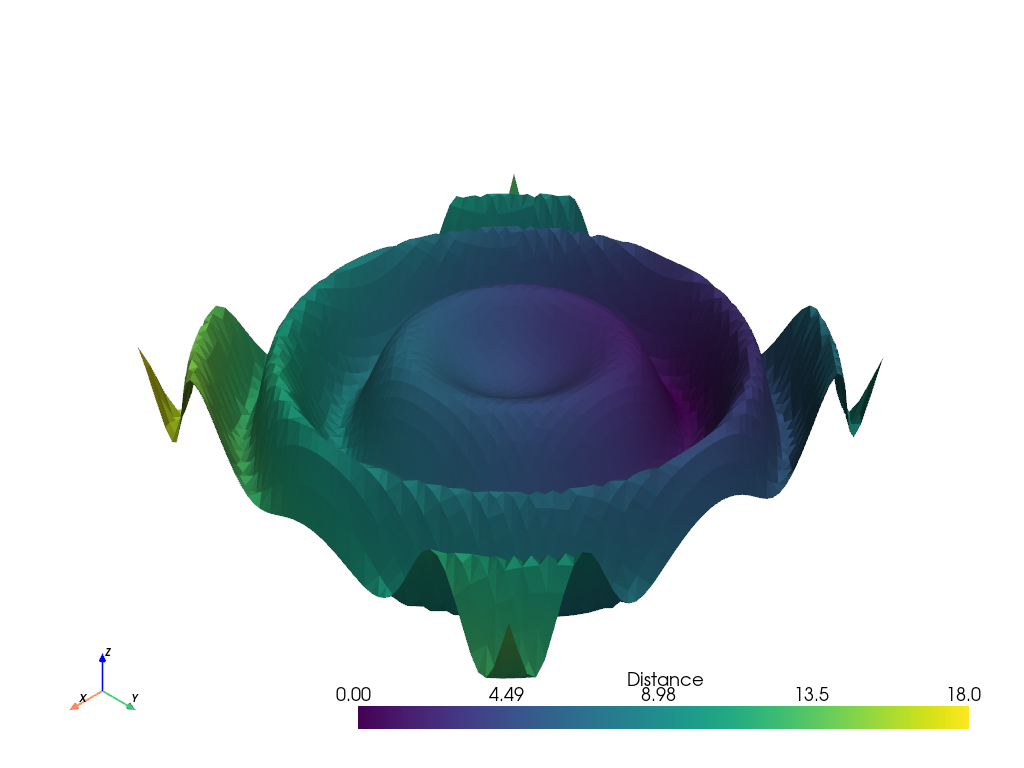

✓ Saved function_omer_test_1_h_0.363_source_2001.txt (h = 0.363, points = 2958)
sparse resolution h = 0.45138606429100037
[                                                  ]                                                   ] 0%

/home/omer.trinin/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


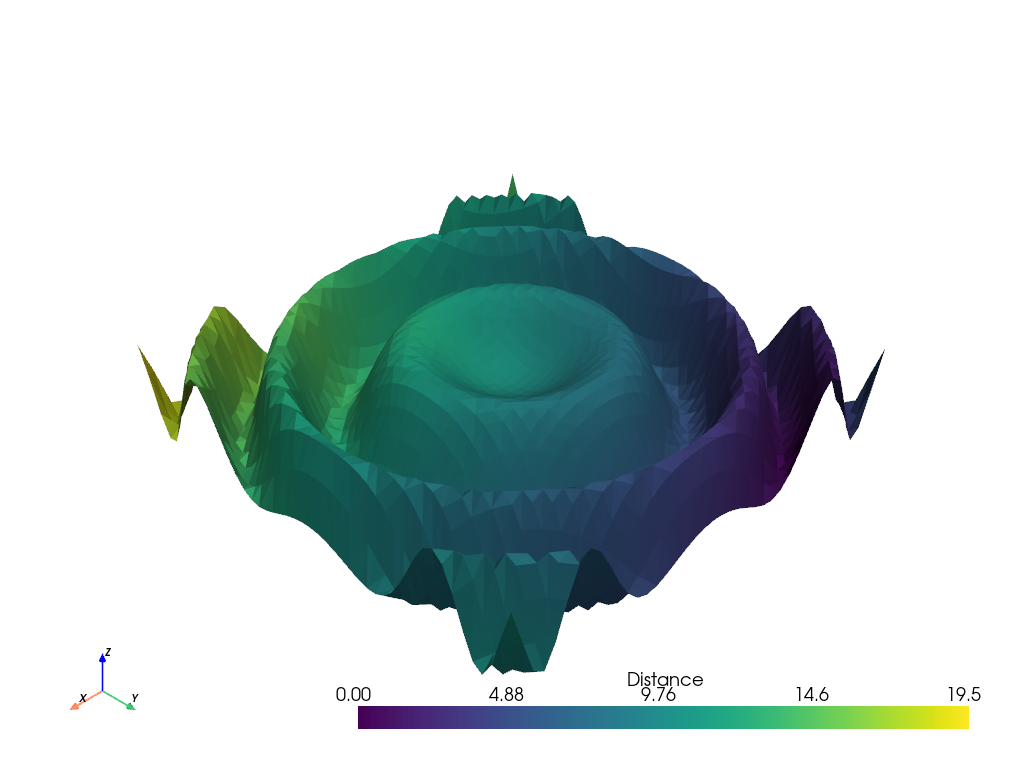

✓ Saved function_omer_test_2_h_0.451_source_1854.txt (h = 0.451, points = 1927)
sparse resolution h = 0.533447802066803
[                                                  ]                                                   ] 0%

/home/omer.trinin/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


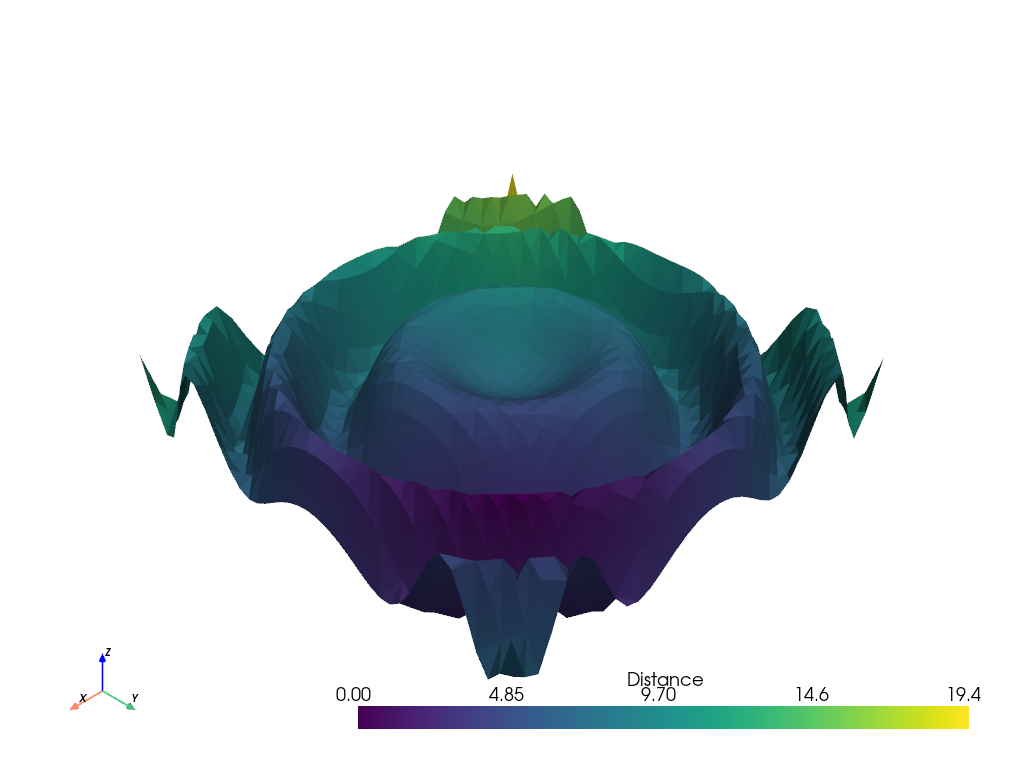

✓ Saved function_omer_test_3_h_0.533_source_1081.txt (h = 0.533, points = 1326)


In [3]:
import random

OUTPUT_DIR = "generated_surfaces/train_surfaces"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define param grids
param_grid = {
    # ripple: [{'A': A, 'k': k} for A in [0.5, 1.0] for k in [1, 2, 2.5]],
    # gaussian_hill: [{'A': A, 'sigma': s} for A in [1, 3] for s in [1.0, 1.5, 2.0]],
    # mexican_hat: [{'A': A, 'sigma': s} for A in [1, 3] for s in [1.0, 1.5, 2.0]],
    # saddle: [{'a': a, 'b': b} for a in [1.5, 2.0] for b in [1.5, 2.0]],
    # paraboloid: [{'a': a, 'b': b} for a in [1.5, 2.0] for b in [1.5, 2.0]],
    # grid_waves: [{'A': A, 'kx': kx, 'ky': ky} for A in [0.3, 0.6] for kx in [2, 3] for ky in [2, 3]],
}
param_grid = {
    omer_test: [{'A': A, 'k': k} for A in [1.0] for k in [0.4]],
}

i=0
# Loop over all surface functions and parameter settings
for f, param_list in param_grid.items():
    for param in param_list:
        # Create a lambda that captures the parameters
        surface_func = lambda x, y, f=f, param=param: f(x, y, **param)
        
        try:
            (graph_high_res, faces_high_res, points3d_high_res, mesh_high_res, h_high_res), sub_meshes, coor_to_index = \
                make_uniform_surface_multimesh(f=surface_func, radius=5, spacing=0.005, sparse_strides=[30, 40, 50, 60])
            print(f'{f.__name__} with params {param}, high resolution h = {h_high_res}')
            mesh_high_res.plot()
        
            for graph_sparse, faces_sparse, points3d_sparse, mesh_sparse, h_sparse in sub_meshes:
                print(f'sparse resolution h = {h_sparse}')
                sparse_source_idx = random.randint(0, len(points3d_sparse) - 1)
                high_res_source_idx = coor_to_index[tuple(points3d_sparse[sparse_source_idx])]
                
                distances_high_res = fmm(V=points3d_high_res, F=faces_high_res, source_index=high_res_source_idx)
                
                sparse_points_tuples = [tuple(p) for p in points3d_sparse]
                mask = [coor_to_index[p] for p in sparse_points_tuples]
                sparse_distances = distances_high_res[mask]
                
                mesh_sparse["Distance"] = sparse_distances
                mesh_sparse.plot(scalars="Distance", cmap="viridis", show_edges=False)
                
                # save file:
                filename = f"function_{f.__name__}_{i}_h_{h_sparse:.3f}_source_{sparse_source_idx}.txt"
                i += 1
                filepath = os.path.join(OUTPUT_DIR, filename)
                with open(filepath, "w") as file:
                    file.write(f"source_idx: {sparse_source_idx}\n")
                    file.write(f"h_value: {h_sparse:.6f}\n\n")

                    file.write("points:\n")
                    for p, d in zip(points3d_sparse, sparse_distances):
                        file.write(f"{p[0]:.6f}, {p[1]:.6f}, {p[2]:.6f}, {d:.6f}\n")

                    file.write("\ngraph:\n")
                    coo = graph_sparse.tocoo()
                    for a, b, w in zip(coo.row, coo.col, coo.data):
                        if a < b:  # write each edge once
                            file.write(f"{a}, {b}, {w:.6f}\n")

                print(f"✓ Saved {filename} (h = {h_sparse:.3f}, points = {len(points3d_sparse)})")
        except Exception as e:
            print(f'Failed for {f.__name__} with params {param}: {e}')